In [1]:
! pip install thop
! pip install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os
import numpy as np
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

2025-07-13 09:16:54.379658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752398214.731674      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752398214.831742      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Create SummaryWriter
writer = SummaryWriter("../tensorboard")

In [4]:
#檢查是否可用gpu
print(torch.cuda.is_available())

True


In [5]:
# 計算normalization需要的 mean & std
def get_mean_std(dataset, ratio=0.3):
    # Get mean and std by sample ratio
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), shuffle=True, num_workers=2)

    data = next(iter(dataloader))[0]     # get the first iteration data
    mean = np.mean(data.numpy(), axis=(0,2,3))
    std = np.std(data.numpy(), axis=(0,2,3))
    return mean, std

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_mean, train_std = get_mean_std(train_dataset)
test_mean, test_std = train_mean, train_std
print(train_mean, train_std)
print(test_mean, test_std)

100%|██████████| 170M/170M [00:01<00:00, 104MB/s]


[0.49070385 0.48101363 0.44511664] [0.2473055  0.243788   0.26141948]
[0.49070385 0.48101363 0.44511664] [0.2473055  0.243788   0.26141948]


In [6]:
##### setting parameter #####
EPOCH = 50
lr = 0.0005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from thop import profile
from torchsummary import summary
import sys
sys.path.append('/kaggle/input/resnet/pytorch/default/1')
from resnet18 import *
##### 使用 thop 計算 FLOPs 和參數數量 #####
# 宣告model
model = ResNet(ResBlock).to(device)
summary(model, (3, 32, 32))

input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
          ResBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [8]:
def train_model(model, trainloader, valloader, epochs):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_losses.append(running_loss / len(trainloader))
        train_accs.append(100 * correct / total)
        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(valloader))
        val_accs.append(100 * correct / total)
        
        print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.2f}, Val Loss {val_losses[-1]:.2f}, Train Acc {train_accs[-1]:.2f}%, Val Acc {val_accs[-1]:.2f}%")

        scheduler.step()
        
    return train_losses, val_losses, train_accs, val_accs

In [9]:
def test_model(model, testloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [10]:
##### data normalization #####
transform_train = transforms.Compose([
    transforms.ToTensor(),

    # data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
    
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=train_mean, std=train_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # data normalization    # standardization: (image - train_mean) / train_std
    transforms.Normalize(mean=test_mean, std=test_std),
])

In [11]:
# dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# 檢查training dataset
#print("trainset length: ", len(trainset))
#print("classes: ", trainset.classes)
image, label = trainset[0]
print("image shape: ", image.shape)
#print("label: ", label)

# Cifar-10的標籤: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# split validation dataset
torch.manual_seed(43)     # 確保每次獲得相同的驗證集
val_size = 5000       # 取5000張驗證集(0.1 of trainset)
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])
print("train length: ", len(train_ds))
print("val length: ", len(val_ds))
print("test length: ", len(test_ds))

# 宣告 batch size
BATCH_SIZE = 128
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

image shape:  torch.Size([3, 32, 32])
train length:  45000
val length:  5000
test length:  10000


In [12]:
model = ResNet(ResBlock)

# print("train with learning rate = 0.0005...")

train_losses, val_losses, train_accs, val_accs = train_model(model, trainloader, valloader, EPOCH)
test_acc = test_model(model, testloader)

print(f"Test Accuracy (without norm): {test_acc:.2f}%")

Epoch 1: Train Loss 1.48, Val Loss 1.31, Train Acc 45.88%, Val Acc 54.22%
Epoch 2: Train Loss 1.02, Val Loss 1.11, Train Acc 63.70%, Val Acc 60.58%
Epoch 3: Train Loss 0.85, Val Loss 0.89, Train Acc 70.05%, Val Acc 68.46%
Epoch 4: Train Loss 0.74, Val Loss 0.93, Train Acc 74.24%, Val Acc 66.84%
Epoch 5: Train Loss 0.66, Val Loss 0.74, Train Acc 76.90%, Val Acc 74.36%
Epoch 6: Train Loss 0.61, Val Loss 0.76, Train Acc 78.99%, Val Acc 74.12%
Epoch 7: Train Loss 0.57, Val Loss 0.68, Train Acc 80.32%, Val Acc 77.14%
Epoch 8: Train Loss 0.54, Val Loss 0.64, Train Acc 81.28%, Val Acc 77.48%
Epoch 9: Train Loss 0.51, Val Loss 0.60, Train Acc 82.26%, Val Acc 79.74%
Epoch 10: Train Loss 0.48, Val Loss 0.79, Train Acc 83.37%, Val Acc 73.66%
Epoch 11: Train Loss 0.47, Val Loss 0.65, Train Acc 84.16%, Val Acc 78.42%
Epoch 12: Train Loss 0.44, Val Loss 0.64, Train Acc 84.97%, Val Acc 78.40%
Epoch 13: Train Loss 0.43, Val Loss 0.59, Train Acc 85.30%, Val Acc 80.38%
Epoch 14: Train Loss 0.41, Val Los

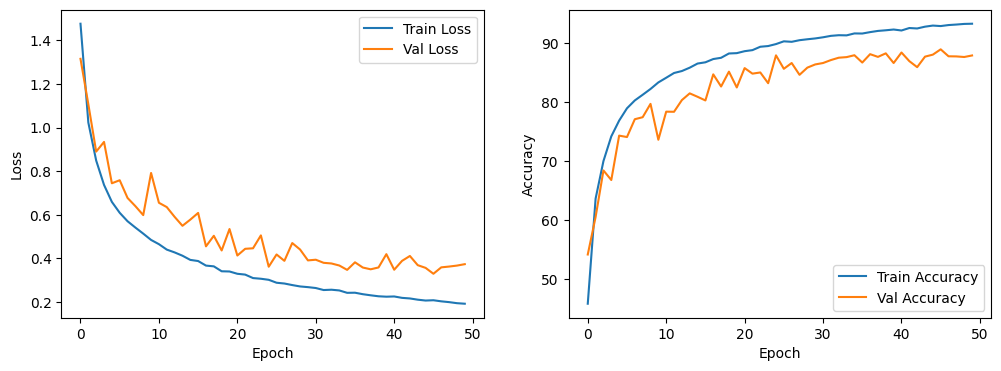

In [13]:
import matplotlib.pyplot as plt

##### 繪製 loss 和 accuracy 的圖 #####
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()